In [8]:
import time
import numpy as np
import gymnasium as gym
from nlk1000_gym import NLK_Env
import matplotlib.pyplot as plt
from matplotlib import colors

# Register the environment
gym.register(
    id='NLK_Env-v0',
    entry_point='nlk1000_gym:NLK_Env'
)
env = gym.make('NLK_Env-v0')

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

class NLK_Sampler:
    #this class is used to sample new electrons
    def __init__(self):
        self.lower = np.array([0.01242802014328473,-2.3510967845422677,    #lower polynom weights, for injection area
                                 135.64889234592374,-2621.6674111929387,8374.6738385004])   
        self.upper = np.array([-0.026705410090359233,6.412451482988342,  #upper polynom weights, for injection area
                                 -549.8383734808201,20891.368558370945,-298723.030031348])
        self.diff = self.upper-self.lower
        self.transform = np.array([-3.2911361375977704,102.00328087158005,
                                   15593.102791660853,-518062.7698926044])
        self.poly = PolynomialFeatures(degree=4)
        self.poly_transform = PolynomialFeatures(degree=3)
    
    def sample(self):
        x = np.random.uniform(size=(1,1))
        x = x**1.8       #fixing term, not known why to use
        x = x*(22.85e-3-15e-3)+15e-3

        x_poly = self.poly_transform.fit_transform(x)
        x = x_poly@self.transform
        x = x*(22.85e-3-15e-3)+15e-3

        x = np.array([[x[0]]])
        

        height = np.random.uniform()
        x_poly = self.poly.fit_transform(x)   #to x^0,x^1,...,x^4
        y = x_poly@self.lower + height*x_poly@self.diff
        return x[0,0],y[0]
    
nlk_sampler = NLK_Sampler()

/home/al3xber/anaconda3/lib/python3.8/site-packages/gymnasium/envs/registration.py:694: UserWarning: WARN: Overriding environment NLK_Env-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")


In [2]:
def optimal_reward_if_kicked(points):
    # given a set of points, calculate how many electrons can be successfully injected given optimal strength
    optimal_NLK_strength_array = np.load("Ztwo_array5.npy")[0]
    round_survived_array = np.load("Zone_array5.npy")[0]
    
    x_list = np.linspace(-100.0e-3,90e-3,1280)
    px_list = np.linspace(-12e-3,7e-3,640)

    x_min, x_max, x_len    = x_list[0], x_list[-1], len(x_list)
    px_min, px_max, px_len = px_list[0], px_list[-1], len(px_list)
    
    x = points[0,:]/env.unwrapped.x_normalization   #100
    px = points[1,:]/env.unwrapped.px_normalization  #1000
    
    
    idx_x  = np.floor(x_len*((x-x_min)/(x_max-x_min))).astype("int")
    idx_px = np.floor(px_len*((px-px_min)/(px_max-px_min))).astype("int")

    valid_idx = (idx_x >= 0)*(idx_x < x_len-1)*(idx_px >= 0)*(idx_px < px_len-1)
    #remove points that are out of the valid area

    x = x[valid_idx]
    px = px[valid_idx]
    idx_x = idx_x[valid_idx]
    idx_px = idx_px[valid_idx]

    rounds_survived = np.vstack([round_survived_array[idx_px,  idx_x],
                                 round_survived_array[idx_px,  idx_x+1],
                                 round_survived_array[idx_px+1,idx_x],
                                 round_survived_array[idx_px+1,idx_x+1]]).T
    
    rounds_survived = np.sum(rounds_survived == 1000,axis=1) 
    valid_idx = rounds_survived > 1  
    #remove points where no neighbor point has survived 1000 rounds

    x = x[valid_idx]
    px = px[valid_idx]
    idx_x = idx_x[valid_idx]
    idx_px = idx_px[valid_idx]

    points = np.vstack([x,px])

    if (points.shape)[1]==0:
        #No electrons survived
        return 0



    #optimal kicker strength calculation

    assert points.shape == np.vstack([x_list[idx_x],px_list[idx_px]]).shape
    #calulate distance to each neighbour in the grid
    distance_matrix = np.vstack([np.sum((points-
                                         np.vstack([x_list[idx_x],px_list[idx_px]]))**2,axis=0),
                                 np.sum((points-
                                         np.vstack([x_list[idx_x],px_list[idx_px+1]]))**2,axis=0),
                                 np.sum((points-
                                         np.vstack([x_list[idx_x+1],px_list[idx_px]]))**2,axis=0),
                                 np.sum((points-
                                         np.vstack([x_list[idx_x+1],px_list[idx_px+1]]))**2,axis=0)]).T

    #normalize
    distance_matrix = distance_matrix/np.sum(distance_matrix,axis=1)[:,None]
    distance_matrix = 1-distance_matrix
    distance_matrix = distance_matrix/np.sum(distance_matrix,axis=1)[:,None]
    
    
    
    assert np.isclose(np.sum(distance_matrix[0]),1.0)
    assert distance_matrix.shape == (len(x),4)

    #get optimal strength
    optimal_NLK_strength_matrix = np.vstack([optimal_NLK_strength_array[idx_px,  idx_x],
                                 optimal_NLK_strength_array[idx_px+1,  idx_x],
                                 optimal_NLK_strength_array[idx_px,idx_x+1],
                                 optimal_NLK_strength_array[idx_px+1,idx_x+1]]).T

    assert distance_matrix.shape == optimal_NLK_strength_matrix.shape

    
    #calculate with approximation how many electrons survive
    optimal_kicker_strength = np.sum(distance_matrix * optimal_NLK_strength_matrix,axis = 1) 
    mean_optimal_kicker_strength = np.mean(optimal_kicker_strength)   
    return ((points.shape[1])/1000)*(985/1000)*np.sum(np.exp(-(14.5*(mean_optimal_kicker_strength-optimal_kicker_strength))**4))/1000

In [5]:
import tqdm

def max_performance_given_env():
    #Perform shown function above on the whole injection set
    env = gym.make('NLK_Env-v0', deterministic = True) #deterministic, to make results comparable
    
    
    
    x_list = np.linspace(15e-3,22.85e-3,180)   
    px_list = np.linspace(-0.0008,0.0012,90)   
    
    Z = np.zeros((180,90))
    Z_round = np.zeros((180,90))
    
    poly = PolynomialFeatures(degree=4)
    nlk_sampler = NLK_Sampler()
    
    extended_x_list = [x for x in x_list for i in range(len(px_list))]
    extended_px_list = np.tile(px_list,(len(x_list),))
        
    new_list = []
    counter = 0
    max_sum = 0
    for i in tqdm.tqdm(range(len(x_list))): 
        x_poly = poly.fit_transform(np.array([[x_list[i]]]))
        x_lower = x_poly@nlk_sampler.lower
        x_upper = x_poly@nlk_sampler.upper
        
        for j in range(len(px_list)):

            if px_list[j]>x_lower and px_list[j]<x_upper:  #check if in injection area
                counter+=1
                
                max_reward, opt_round = performance_on_point(x_list[i],px_list[j],env) #calculate max reward
                max_reward *= env.unwrapped.reward_normalization
                
                #save info
                Z[i,j] = max_reward
                Z_round[i,j] = opt_round
                max_sum += max_reward
            else:
                Z[i,j] = np.nan
                Z_round[i,j] = np.nan
    print("Number of interesting points:",counter)
    return max_sum/counter, Z, Z_round

def performance_on_point(x,px,env):
    #we run the optimal_reward_if_kicked in all rounds and return the best round+number of electrons survived
    obs, info = env.reset(options = {"x,px" : (x,px)})    #set observation to x,px points
    points = env.unwrapped.points    
        
    done = False
    counter = 0

    max_reward = 0
    while not done:
        #check in each round
        #reward if kicked now
        opt_reward_given_round = optimal_reward_if_kicked(points)   

        #possibly update best reward
        if opt_reward_given_round > max_reward:
            max_reward = opt_reward_given_round
            opt_round = counter
        #propagate to next round
        obs, reward, done,_, _ = env.step(np.array([np.float32(0.0)]))
        points = env.unwrapped.points
        
        #if reward is already high, finish, to save time
        if max_reward > 0.984:  #highest reward is 0.985
            break
        counter += 1


    return max_reward, opt_round


In [6]:
value, Z, Z_round = max_performance_given_env()
value

100%|██████████| 180/180 [07:02<00:00,  2.35s/it]

Number of interesting points: 8944


676.6172175999003

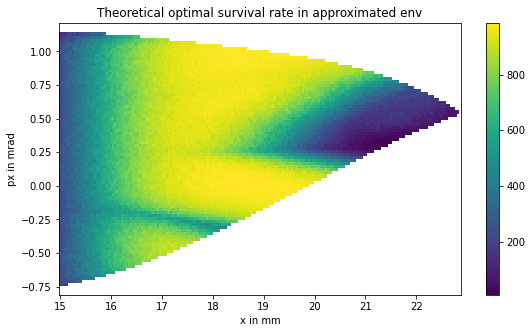

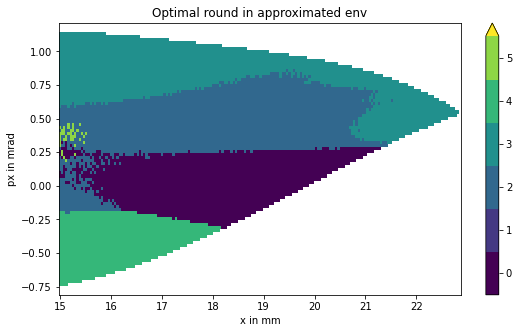

In [9]:
x_list = np.linspace(15e-3,22.85e-3,180)   
px_list = np.linspace(-0.0008,0.0012,90) 

fig, ax = plt.subplots(figsize=(9,5))

pc = ax.pcolormesh(x_list*1000,px_list*1000,Z.T,shading='auto')
fig.colorbar(pc)
 
plt.title(f"Theoretical optimal survival rate in approximated env")
plt.ylabel("px in mrad")
plt.xlabel("x in mm")
plt.show()


bounds = np.linspace(0, 6, 6 +1)
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256, extend="max")

fig, ax = plt.subplots(figsize=(9,5))


pc = ax.pcolormesh(x_list*1000,px_list*1000,Z_round.T,shading='auto',norm=norm)

cb=fig.colorbar(pc)


label_bounds = bounds[:-1]

cb.set_ticks(label_bounds + 0.5)
cb.set_ticklabels([f"{int(b):d}" for b in label_bounds]) 
    
    
plt.title(f"Optimal round in approximated env")
plt.ylabel("px in mrad")
plt.xlabel("x in mm")
plt.show()